In [128]:

from IPython.display import clear_output 
clear_output()
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# progress bar in repeated code
from tqdm import tqdm
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import seaborn as sns
import missingno as msno

# Scoring
from sklearn.metrics import f1_score

# Model
import catboost

In [149]:
import pandas as pd
import random
import os
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# !pip install catboost
import catboost

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test = test_df.drop(columns=['PRODUCT_ID'])

# Preprocessing - Imputer

In [150]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i]) 
print('Done.')    

Done.


In [151]:
# Normlize
# different sacles of data will lead the KNN Imputer to genrate biased replacements

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_x = pd.DataFrame(scaler.fit_transform(train_x))
# test_x = pd.DataFrame(scaler.transform(test_x))

In [152]:
# KNN Imputer 
from sklearn.impute import KNNImputer

# Define columns with missing values
missing_cols = ['X_{}'.format(i) for i in range(1, 3327)]

# Impute missing values using KNN imputer on train data
imputer = KNNImputer(n_neighbors=5)   # n_neighbors: params
imputer.fit(train_x)
                                 
train_x = imputer.transform(train_x)    
test_x = imputer.transform(test)   

In [153]:
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test)
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,3244,3245,3246,3247,3248,3249,3250,3251,3252,3253
0,4.0,2.0,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.1890,0.000006
1,5.0,2.0,2.0,96.0,0.0,45.0,10.0,0.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.1850,0.000029
2,5.0,2.0,2.0,95.0,0.0,45.0,10.0,0.0,60.0,10.0,...,0.000007,0.000003,0.189576,0.000032,0.000692,0.000040,0.000003,0.000003,0.1878,0.000030
3,5.0,2.0,2.0,87.0,0.0,45.0,10.0,0.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.1880,0.000031
4,5.0,2.0,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.000007,0.000003,0.190030,0.000031,0.000674,0.000039,0.000003,0.000003,0.1870,0.000029


# Modeling

# Feature Importance
- Feature Importance는 학습된 모델에서 주로 사용된 컬럼들을 나타내기 때문에, 학습에 도움이 되지 않은 컬럼을 지워준다고 해도 test predict에 영향력이 적다.
- 줄어든 컬럼으로 학습 방식이 바뀌고, overfit을 완화하여 더 나은 결과를 유도할 수 있다.

In [154]:
test.describe()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
count,535.000000,535.000000,489.000000,489.000000,489.0,489.000000,489.000000,489.0,489.000000,489.000000,...,153.000000,1.530000e+02,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02,153.000000,153.000000
mean,4.351402,1.824299,2.593047,94.670757,0.0,45.004090,10.269939,0.0,48.572597,10.002045,...,0.000007,3.678431e-06,0.190252,0.000022,0.000940,0.000033,0.000003,2.251758e-06,0.188418,0.000019
std,0.907662,0.563370,9.967778,4.162181,0.0,0.063887,0.444382,0.0,3.437877,0.045222,...,0.000001,6.711068e-07,0.000804,0.000011,0.000284,0.000010,0.000001,6.591602e-07,0.001537,0.000012
min,0.000000,0.000000,1.000000,87.000000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,...,0.000005,2.490000e-06,0.188201,0.000007,0.000642,0.000019,0.000002,6.470000e-07,0.185000,0.000003
25%,4.000000,2.000000,1.000000,91.000000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,...,0.000007,3.260000e-06,0.189574,0.000010,0.000670,0.000023,0.000003,1.680000e-06,0.187000,0.000006
50%,5.000000,2.000000,2.000000,95.000000,0.0,45.000000,10.000000,0.0,50.000000,10.000000,...,0.000007,3.430000e-06,0.190208,0.000031,0.000721,0.000039,0.000003,2.520000e-06,0.189000,0.000028
75%,5.000000,2.000000,2.000000,97.000000,0.0,45.000000,11.000000,0.0,51.000000,10.000000,...,0.000008,4.000000e-06,0.190872,0.000032,0.001230,0.000042,0.000004,2.780000e-06,0.190000,0.000030
max,5.000000,2.000000,158.000000,102.000000,0.0,46.000000,11.000000,0.0,64.000000,11.000000,...,0.000012,6.530000e-06,0.192250,0.000036,0.001320,0.000049,0.000007,3.550000e-06,0.191000,0.000034


In [ ]:
feat_list = []
for _ in range(5):
    clf = catboost.CatBoostClassifier(verbose=0, thread_count=5) # task_type='GPU'
    clf.fit(train_x, train_y, 
            # early_stopping_rounds=100, 
            # cat_features=['PRODUCT_CODE', 'LINE']
            )

    feat_list.append(clf.feature_importances_)

feat_list = np.array(feat_list)
feat_max = np.array([max(feat_list[:, i]) for i in range(len(feat_list[0]))])    
feature_imp = pd.Series(feat_max, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()
train_x = train_x[train_x.columns[feat_max>0.5]]  
# train_x.columns = train_x.columns.to_list()
test = test[train_x.columns]  

# Visualization
plt.rcParams["figure.figsize"] = (10, 15)
plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()     



In [ ]:
# train_x = train_x[feat_max]
# test = test[feat_max]

# # 영향력이 있는 모든 컬럼 출력
# for c in train_x.columns:
#     print(f'"{c}"', end=', ')

# Modeling

In [ ]:
clf = catboost.CatBoostClassifier(verbose=0, thread_count=5)
fitted = clf.fit(train_x, train_y)
pred = clf.predict(test)
submit['Y_Class'] = pred
submit.Y_Class.value_counts()  

1    467
0     36
2     32
Name: Y_Class, dtype: int64

In [119]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

clf = LGBMClassifier(verbose=0, thread_count=5)
fitted = clf.fit(train_x, train_y)
preds = clf.predict(test_x)   


[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [120]:
pred = pd.DataFrame(preds)
pred.value_counts()

1    420
2     71
0     44
dtype: int64

In [124]:
models = [
    # test set accuracy
    LGBMClassifier(verbose=0, thread_count=5, random_seed=37),
    # test set accuracy
    XGBClassifier(random_state=37),
    # test set accuracy  
    CatBoostClassifier(verbose=0, random_state=37)]

fit = [x.fit(train_x, train_y) for x in models]    

[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.686213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.079629
0:	learn: 1.0458323	total: 523ms	remaining: 8m 42s
1:	learn: 1.0044632	total: 905ms	remaining: 7m 31s
2:	learn: 0.9697559	total: 1.28s	remaining: 7m 5s
3:	learn: 0.9386880	total: 1.66s	remaining: 6m 53s
4:	learn: 0.9112284	total: 2.03s	remaining: 6m 43s
5:	learn: 0.8878815	total: 2.4s	remaining: 6m 38s
6:	learn: 0.8674621	total: 2.78s	remaining: 6m 34s
7:	learn: 0.8510101	total: 3.14s	remaining: 6m 29s
8:	learn: 0.8338051	total: 3.53s	remaining: 6m 28s
9:	learn: 0.8202849	total: 4

1    423
2     73
0     39
dtype: int64

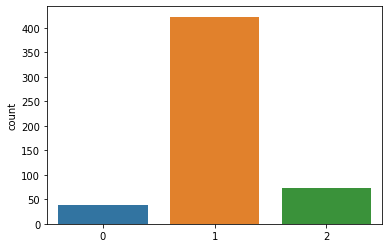

In [125]:
def prediction(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = prediction(models, test_x, 'hard', [2,1,2] )

sns.countplot(x=preds);   
pd.DataFrame(preds).value_counts()

In [126]:
pred = pd.DataFrame(preds)
pred.value_counts()

1    423
2     73
0     39
dtype: int64

In [127]:
submit = pd.read_csv('sample_submission.csv')

submit['Y_Class'] = preds

submit.to_csv('KNNimpute-LXC212.csv', index=False)

# sns.countplot(x=pred)
# pred.value_counts()

In [121]:
# cross_val_score: CV 검증 set 성능 평가 
from sklearn.model_selection import cross_val_score, cross_validate
score = cross_val_score(fitted, 
                        train_x, train_y, 
                        scoring="accuracy", 
                        cv=5)  # k=5 fold 

print("교차 검증별 정확도:", np.round(score, 3))
print("평균 검증 정확도:", np.mean(score).round(3), "+/-", np.std(score).round(3))


[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: t

In [ ]:
# 정규화 --> 성능 down 
